In [1]:
from PIL import Image
from model import AggMInterface
from data import DInterface
import yaml
import warnings
warnings.filterwarnings("ignore")

# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_1/hparams.yaml"
checkpoint_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_1/checkpoints/dinov2_backbone_epoch(15)_step(15632)_R1[0.8946]_R5[0.9554]_R10[0.9608].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path) as f:
    config = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module = DInterface(**config)  # 数据模块初始化，传入配置参数
transform = data_module.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()
model = model.model.model
model.requires_grad_(False)

/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/utils/hook_func.py:21: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


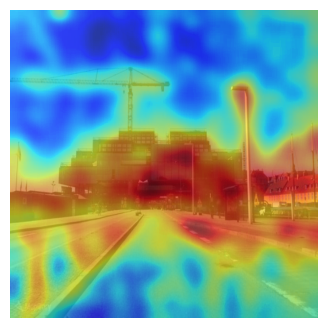

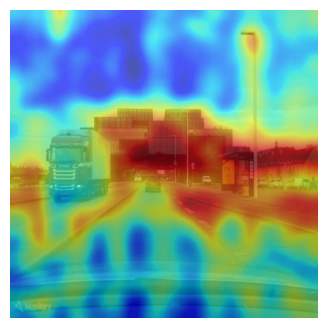

torch.Size([1, 1, 1600, 1024]) torch.Size([1, 1, 1600, 1024])
torch.Size([1600]) torch.Size([1600])
40 40
互为最佳匹配的点对数量: 350
基于显著性掩码过滤后的点对数量: 30


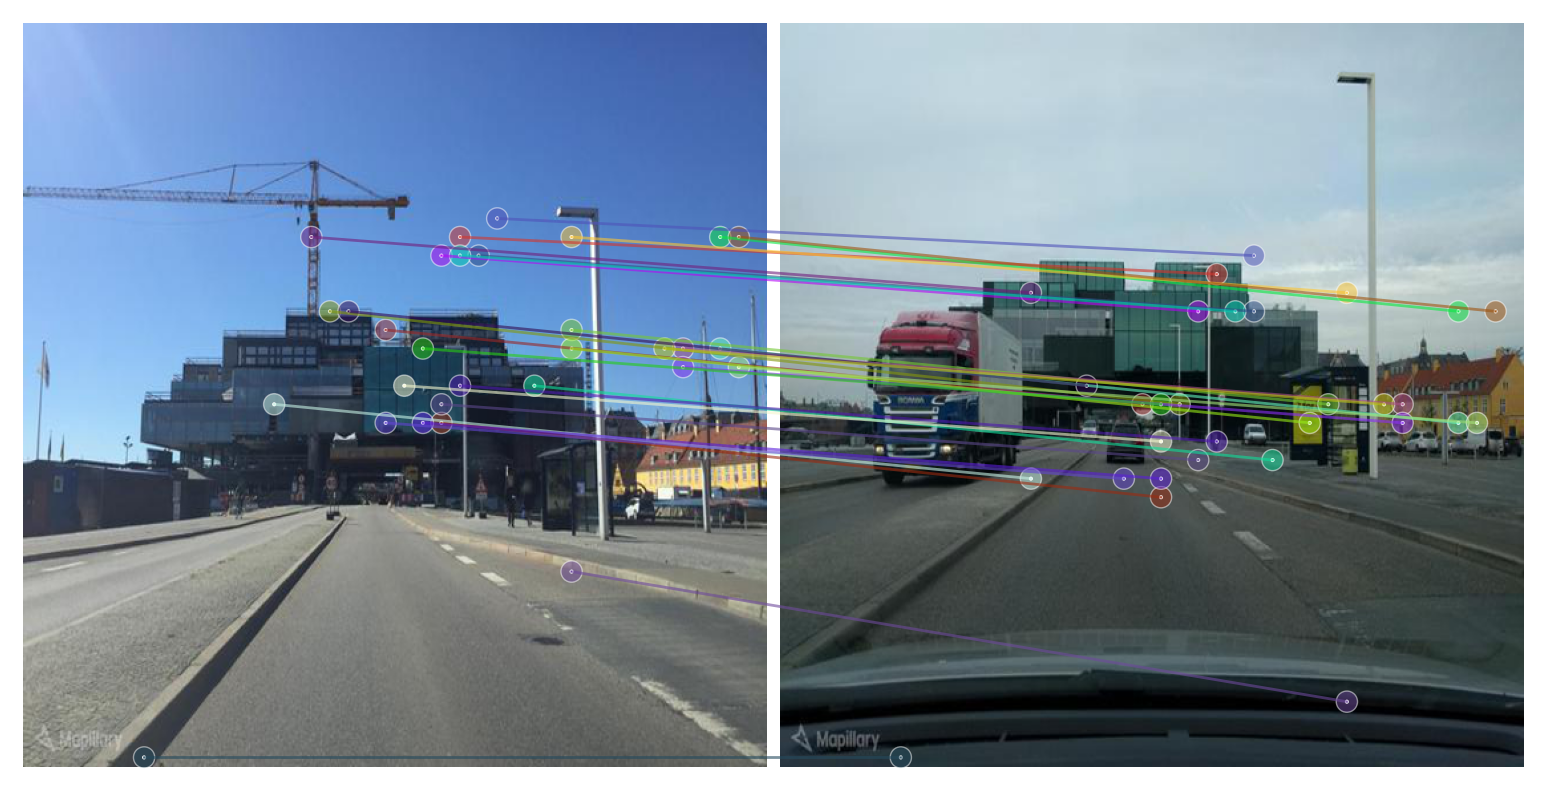

In [4]:
from utils.hook_func import find_correspondences, draw_correspondences, draw_correspondences_with_lines
from utils.hook_func import extract_saliency_maps
from visualization import visualize_saliency_maps

# 指定图像路径
image_path1 = "sample_imgs/msls/3/query/oYwU28V-MzaKyX9R18zlMQ.jpg"
image_path2 = "sample_imgs/msls/3/ref/aEfMlCMFxwR_QY-e5KvTDw.jpg"

# 指定特征层和显著性图层
facet_layer_and_facet = {17: 'value'}
saliency_map_layer_and_facet = {23: 'attn'}
thresh = 0.6
num_pairs = 30
bin = False
hierarchy = 1

# 可视化显著性图
image1 = Image.open(image_path1).convert("RGB")
image2 = Image.open(image_path2).convert("RGB")
# 应用数据变换并将图像转移到GPU
image1 = transform(image1).unsqueeze(0).cuda()
image2 = transform(image2).unsqueeze(0).cuda()
# 可视化显著性图
saliency_map1 = extract_saliency_maps(model, saliency_map_layer_and_facet, image1)[0].cuda()  
saliency_map2 = extract_saliency_maps(model, saliency_map_layer_and_facet, image2)[0].cuda()
visualize_saliency_maps(image1, saliency_map1, alpha=0.6, cmap='jet', save_path=None, figsize=(4,4), sigma=1.0)
visualize_saliency_maps(image2, saliency_map2, alpha=0.6, cmap='jet', save_path=None, figsize=(4,4), sigma=1.0)

# 计算对应点    
points1, points2, image1, image2 = find_correspondences(
    model,
    transform,  
    image_path1,
    image_path2,
    facet_layer_and_facet=facet_layer_and_facet,
    saliency_map_layer_and_facet=saliency_map_layer_and_facet,
    bin=bin,
    include_cls=False,
    thresh=thresh,
    num_pairs=num_pairs,
    hierarchy=hierarchy,
)

# 可视化对应点
fig = draw_correspondences_with_lines(points1, points2, image1, image2)
fig.show()